<a href="https://colab.research.google.com/github/finesketch/deep_learning/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20Prediction/Course4_Part4_Lesson5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [10]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [8]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-12-19 22:28:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 108.177.13.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-12-19 22:28:58 (89.6 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



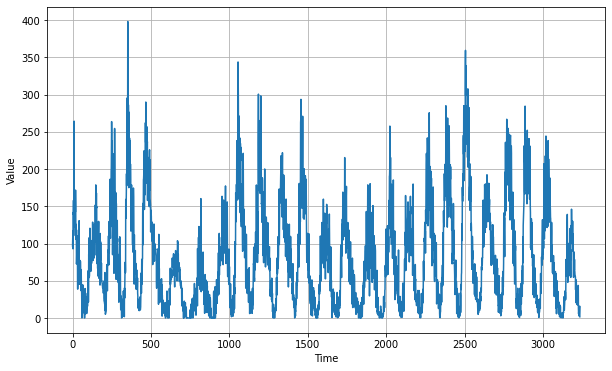

In [11]:
import csv

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time, series)

In [12]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  print(series[:])
  series = tf.expand_dims(series, axis=-1)
  print(series[:])
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [14]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [16]:
window_size = 64
batch_size = 256

In [17]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

[ 96.7 104.3 116.7 ...  78.5  97.3 119.2]
tf.Tensor(
[[ 96.7]
 [104.3]
 [116.7]
 ...
 [ 78.5]
 [ 97.3]
 [119.2]], shape=(3000, 1), dtype=float64)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 7s 308ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 4s 301ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 4s 295ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 4s 300ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 4s 298ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 4s 296ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 4s 298ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 4s 295ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 4s 299ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/12 [==============================] - 4s 305ms/step - loss: 50.9453 - mae: 51.4415
Epoch 11/100
12/12 

(1e-08, 0.0001, 0.0, 60.0)

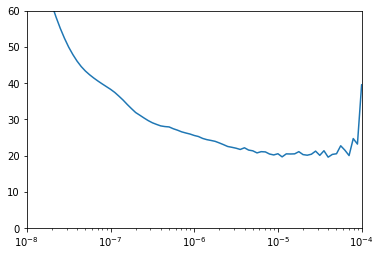

In [19]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

In [20]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

52.538204

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [23]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=500)

[ 96.7 104.3 116.7 ...  78.5  97.3 119.2]
tf.Tensor(
[[ 96.7]
 [104.3]
 [116.7]
 ...
 [ 78.5]
 [ 97.3]
 [119.2]], shape=(3000, 1), dtype=float64)
Epoch 1/500
30/30 [==============================] - 7s 124ms/step - loss: 67.1643 - mae: 67.6625
Epoch 2/500
30/30 [==============================] - 4s 125ms/step - loss: 24.2131 - mae: 24.7073
Epoch 3/500
30/30 [==============================] - 4s 120ms/step - loss: 22.6612 - mae: 23.1555
Epoch 4/500
30/30 [==============================] - 4s 124ms/step - loss: 22.4110 - mae: 22.9046
Epoch 5/500
30/30 [==============================] - 4s 125ms/step - loss: 20.8780 - mae: 21.3714
Epoch 6/500
30/30 [==============================] - 4s 126ms/step - loss: 20.3595 - mae: 20.8524
Epoch 7/500
30/30 [==============================] - 4s 126ms/step - loss: 20.5074 - mae: 20.9999
Epoch 8/500
30/30 [==============================] - 4s 127ms/step - loss: 20.1431 - mae: 20.6364
Epoch 9/500
30/30 [==============================] - 4s 124ms/step - l

In [25]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

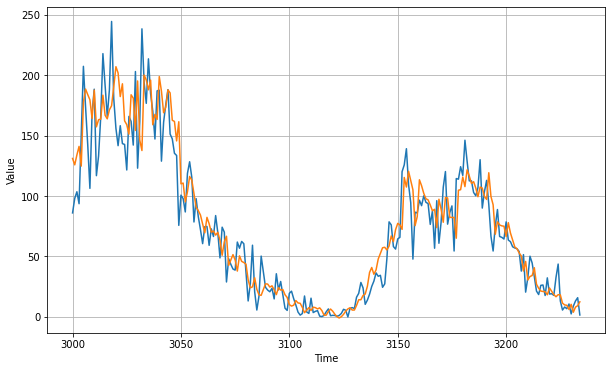

In [26]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.144722

<Figure size 432x288 with 0 Axes>

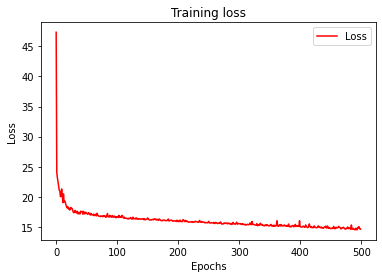

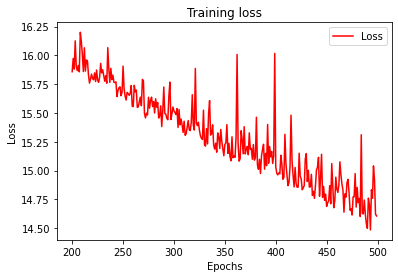

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()